In [13]:
import torch
import torchvision
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

In [14]:
transform = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
validation, training_data, validation_labels, training_labels = \
    train_test_split(data_set.data, data_set.targets, train_size=1 / 6)

In [3]:
print(validation.size(), training_data.size())

torch.Size([10000, 28, 28]) torch.Size([50000, 28, 28])


In [15]:
def to_cells(pic, k_cells):
    n_slices = np.sqrt(k_cells)
    assert int(n_slices + 0.5) ** 2 == k_cells
    n_slices = n_slices.astype(np.int)
    [w, h] = 28, 28
    r = np.linspace(0, w, n_slices + 1)
    r_tuples = [(np.int(r[i]), np.int(r[i + 1])) for i in range(0, len(r) - 1)]
    q = np.linspace(0, h, n_slices + 1)
    q_tuples = [(np.int(q[i]), np.int(q[i + 1])) for i in range(0, len(q) - 1)]
    cell = []
    for row in range(n_slices):
        for column in range(n_slices):
            [x1, y1, x2, y2] = *r_tuples[row], *q_tuples[column]
            cell.append(pic[x1:y1, x2:y2])
    return cell

In [16]:
def feature(image):
    density = torch.count_nonzero(image)
    image = to_cells(image, 16)
    features = []
    for i in range(16):
        first_feature = torch.count_nonzero(image[i]) / density
        x, y = image[i], image[i]
        model = LinearRegression()
        model.fit(x, y)
        slope = model.coef_[0][0]
        second_feature = 2 * slope / (1 + slope ** 2)
        third_feature = (1 - slope ** 2) / (1 + slope ** 2)
        features.append(first_feature.item())
        features.append(second_feature)
        features.append(third_feature)
    return torch.Tensor(features)

In [6]:
training_with_features = []
for j in range(len(training_data)):
    training_with_features.append(feature(training_data[j]))

In [7]:
validation_with_features = []
for n in range(len(validation)):
    validation_with_features.append(feature(validation[n]))

In [17]:
PATH = 'model_1.pth'
my_model = nn.Sequential(nn.Linear(48, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 10))
my_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
training_loader = []
for elt in range(len(training_with_features)):
    training_loader.append((training_with_features[elt], training_labels[elt].item()))

In [10]:
validation_loader = []
for elt in range(len(validation_with_features)):
    validation_loader.append((validation_with_features[elt], validation_labels[elt].item()))

In [11]:
training_loader = torch.utils.data.DataLoader(training_loader, batch_size=16)
validation_loader = torch.utils.data.DataLoader(validation_loader, batch_size=16)

In [41]:
loss = nn.CrossEntropyLoss()
optimisation = torch.optim.Adam(my_model.parameters(), lr=0.001)

In [42]:
epochs = 100
for p in range(epochs):
    print('For the {} training '.format(p + 1))
    loss_app = 0.0
    for data in training_loader:
        inputs, labels = data
        my_model.zero_grad()
        outputs = my_model(torch.flatten(inputs, start_dim=1))
        loss_app = loss(outputs, labels)
        loss_app.backward()
        optimisation.step()

    loss_val = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data
            outputs = my_model(torch.flatten(inputs, start_dim=1))

            loss_val = loss(outputs, labels)
            for idx, l in enumerate(outputs):
                if torch.argmax(l) == labels[idx]:
                    correct += 1
                total += 1
        loss_avg_validation = correct / total
        loss_avg_validation = round(loss_avg_validation, 3)

    print("training loss : {}, validation loss {} and precision {}".format(loss_app, loss_val, loss_avg_validation))

For the 1 training 
training loss : 0.5265935063362122, validation loss 0.5491381287574768 and precision 0.845
For the 2 training 
training loss : 0.5314667224884033, validation loss 0.5633441209793091 and precision 0.844
For the 3 training 
training loss : 0.5321543216705322, validation loss 0.5806108713150024 and precision 0.844
For the 4 training 
training loss : 0.5244475603103638, validation loss 0.5942559242248535 and precision 0.845
For the 5 training 
training loss : 0.5234931707382202, validation loss 0.6000617742538452 and precision 0.845
For the 6 training 
training loss : 0.532001256942749, validation loss 0.6102816462516785 and precision 0.846
For the 7 training 
training loss : 0.5242199301719666, validation loss 0.6141124367713928 and precision 0.845
For the 8 training 
training loss : 0.5300406813621521, validation loss 0.6233878135681152 and precision 0.847
For the 9 training 
training loss : 0.5416330099105835, validation loss 0.6270130276679993 and precision 0.847
Fo

tensor(1)


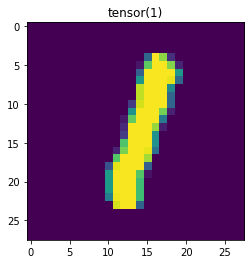

In [22]:
test=feature(validation[20])#Features extraction of the image
print(validation_labels[20])#Printing the real label of the image
plt.imshow(validation[20].view(28,28))
plt.title(torch.argmax(my_model((test))))#Adding the predicted label to the title
plt.show()

In [60]:
PATH = 'model_1.pth'
torch.save(my_model.state_dict(), PATH)

In [23]:
PATH = 'model_1.pth'
the_model = nn.Sequential(nn.Linear(48, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 10))
the_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
the_model.eval()

Sequential(
  (0): Linear(in_features=48, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=10, bias=True)
)

tensor(3)
torch.Size([28, 28])


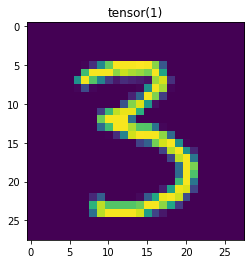

In [25]:
print(validation_labels[49])
print(validation[49].shape)
plt.imshow(validation[49].view(28,28))
plt.title(torch.argmax(the_model((test))))
plt.show()

In [29]:
import cv2
import numpy as np
def image_read(img):        
        image = cv2.imread(cv2.samples.findFile(img))


        
        dimention = (28,28)
        
        image = cv2.resize(image,dimention,interpolation = cv2.INTER_AREA)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)




        
        plt.imshow(image)
        
        plt.show()


        
        image = torch.Tensor(image)
        
        image = feature(image)
        
        pred = the_model(image)
        
        print('lapred',torch.argmax(pred))
        
        print(image.shape)

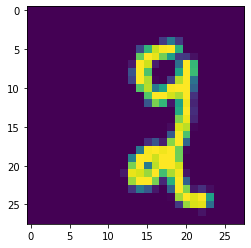

lapred tensor(2)
torch.Size([48])


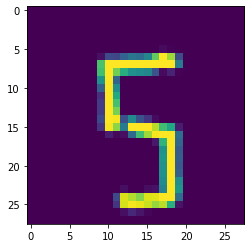

lapred tensor(1)
torch.Size([48])


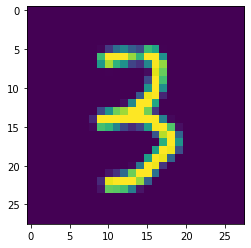

lapred tensor(3)
torch.Size([48])


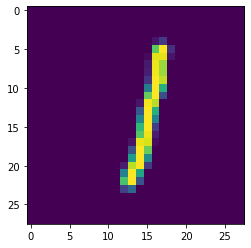

lapred tensor(1)
torch.Size([48])


In [30]:
drawing = False
def draw(event, x, y, flags, param):
  global drawing

  if event == cv2.EVENT_LBUTTONDOWN:
    drawing = True
  elif event == cv2.EVENT_LBUTTONUP:
    drawing = False
  elif event == cv2.EVENT_MOUSEMOVE:
    if drawing == True:
      cv2.circle(img1, (x,y), 5, (255,0,0), -1)

img1 = np.zeros((150,150,1),np.uint8)
cv2.namedWindow("image")
cv2.setMouseCallback("image",draw)
while(1):
    cv2.imshow("image",img1)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('s'):
        break
    elif k == ord('p'):
        cv2.imwrite('resized.png', img1)
        image_read('resized.png')
        img1 = np.zeros((150,150,1), np.uint8)
        
    elif k == ord('c'):
        img1 = np.zeros((150,150,1), np.uint8)
cv2.destroyAllWindows()

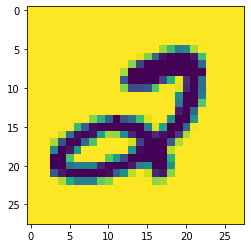

lapred tensor(0)
torch.Size([48])


In [27]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

image = cv2.imread(cv2.samples.findFile("5.png"))

dimention = (28,28)
image = cv2.resize(image,dimention,interpolation = cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


plt.imshow(image)
plt.show()

image = torch.Tensor(image)
image = feature(image)
pred = model(image)
print('lapred',torch.argmax(pred))
print(image.shape)